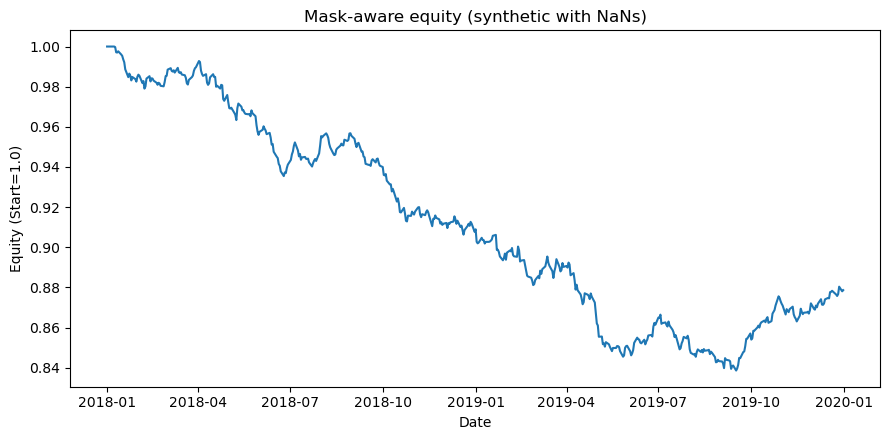

{'ann_sharpe': -1.643621602961168,
 'cagr': -0.060566353622281355,
 'tot_return': -0.1213941586199363,
 'ann_vol': 0.03757876198347862,
 'max_drawdown': -0.1614353093233144}

In [1]:
# Alpha backtesting toolkit for a 3000 x T (stocks x days) alpha matrix.
# The functions are vectorized and accept pandas DataFrames where
# rows = trading dates, columns = tickers.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from typing import Optional, Dict

# -----------------------------
# Core utilities
# -----------------------------

def build_tradable_mask(
    close: pd.DataFrame,
    volume: pd.DataFrame,
    min_price: float = 1.0,
    min_vol: float = 1.0,
) -> pd.DataFrame:
    """
    Return a boolean (dates × tickers) mask where a name is tradable iff:
      - close and volume are finite
      - close >= min_price
      - volume >= min_vol
    You can AND this with your top-3000 membership mask if you have one.
    """
    mask = (
        close.notna() & volume.notna() &
        np.isfinite(close) & np.isfinite(volume) &
        (close >= min_price) & (volume >= min_vol)
    )
    return mask


# -----------------------------
# Weight construction (mask-aware)
# -----------------------------

def _zscore_cross_section_masked(x: pd.Series, mask: Optional[pd.Series]) -> pd.Series:
    if mask is not None:
        x = x.where(mask)
    mu = x.mean(skipna=True)
    sd = x.std(ddof=1, skipna=True)
    if np.isnan(sd) or sd == 0:
        return x * 0.0
    return (x - mu) / sd

def make_weights(
    alpha: pd.DataFrame,
    gross_exposure: float = 1.0,
    cap_per_name: float = None,
    neutralize: bool = True,
    method: str = "rank",
    winsor_pct: float = 0.01,
    mask: Optional[pd.DataFrame] = None,
    min_names: int = 5,
) -> pd.DataFrame:
    """
    Convert alpha (T x N) to daily weights with optional 'mask' to ignore inactive names.
    - 'mask' should be boolean (dates × tickers). Non-tradables get weight = 0.
    - If active names < min_names, row is zeroed.
    """
    alpha = alpha.copy()

    # Apply mask upfront so alpha for inactive names doesn't affect ranks/means
    if mask is not None:
        alpha = alpha.where(mask)

    # Winsorize cross-sectionally
    if winsor_pct and winsor_pct > 0:
        q_low = alpha.quantile(winsor_pct, axis=1, interpolation="linear")
        q_high = alpha.quantile(1 - winsor_pct, axis=1, interpolation="linear")
        alpha = alpha.clip(lower=q_low, upper=q_high, axis=0)

    # Cross-sectional transform
    if method == "rank":
        # Rank only among active names each day
        ranks = alpha.rank(axis=1, method="average", na_option="keep", pct=True)
        x = ranks * 2 - 1
    elif method == "zscore":
        # Row-wise z-score with mask
        x = pd.DataFrame(
            {c: alpha[c] for c in alpha.columns},
            index=alpha.index,
        )
        x = x.apply(lambda row: _zscore_cross_section_masked(row, None), axis=1)
    else:
        x = alpha
    # Neutralize (sum to zero among active)
    if neutralize:
        row_means = x.mean(axis=1, skipna=True)
        x = x.sub(row_means, axis=0)

    # Zero out inactive names explicitly
    if mask is not None:
        x = x.where(mask, 0.0)

    # Avoid over-scaling when too few names
    active_counts = x.replace(0.0, np.nan).notna().sum(axis=1)
    x.loc[active_counts < min_names, :] = 0.0

    # Scale to target gross
    abs_sum = x.abs().sum(axis=1).replace(0, np.nan)
    w = x.div(abs_sum, axis=0) * gross_exposure
    w = w.fillna(0.0)

    # Per-name cap, then re-scale
    if cap_per_name is not None:
        w = w.clip(lower=-cap_per_name, upper=cap_per_name)
        abs_sum = w.abs().sum(axis=1).replace(0, np.nan)
        w = w.div(abs_sum, axis=0) * gross_exposure
        w = w.fillna(0.0)

    # Final mask
    if mask is not None:
        w = w.where(mask, 0.0)

    return w


# -----------------------------
# Backtest (mask-aware)
# -----------------------------

def backtest_long_short(
    weights: pd.DataFrame,
    returns: pd.DataFrame,
    cost_bps: float = 5.0,
) -> Dict[str, pd.Series]:
    """
    - Uses lagged weights: w_{t-1} * r_t
    - Zeroes weights on days where returns are NaN (not tradable)
    - Turnover is computed on *tradable* weights; when a name leaves the universe,
      we count the trade to zero on that day.
    """
    # Align
    weights = weights.reindex_like(returns).fillna(0.0)

    # Mask for tradable at t (returns non-NaN)
    tradable = returns.notna()

    # Lag weights and zero them where next-day return is NaN
    w_lag = weights.shift(1).where(tradable, 0.0).fillna(0.0)

    # P&L
    pnl = (w_lag * returns.fillna(0.0)).sum(axis=1)

    # Turnover: changes in *current* weights among tradables
    w_now = weights.where(tradable, 0.0).fillna(0.0)
    w_prev = weights.shift(1).where(tradable.shift(0).fillna(False), 0.0).fillna(0.0)
    dw = (w_now - w_prev)
    two_way_turnover = dw.abs().sum(axis=1)
    one_way_turnover = 0.5 * two_way_turnover

    # Costs on one-way
    cost = one_way_turnover * (cost_bps / 10000.0)
    ret_net = pnl - cost

    return {
        "ret_gross": pnl,
        "ret_net": ret_net,
        "one_way_turnover": one_way_turnover,
        "two_way_turnover": two_way_turnover,
        "weights_used": w_lag,
    }


def performance_stats(ret: pd.Series) -> Dict[str, float]:
    ret = ret.dropna()
    if ret.empty:
        return {"ann_sharpe": np.nan, "cagr": np.nan, "tot_return": np.nan, "ann_vol": np.nan, "max_drawdown": np.nan}
    ann = 252.0
    mu = ret.mean()
    sd = ret.std(ddof=1)
    ann_sharpe = (mu / sd) * np.sqrt(ann) if sd != 0 else np.nan
    equity = (1 + ret).cumprod()
    years = len(ret) / ann
    cagr = equity.iloc[-1] ** (1 / years) - 1 if years > 0 else np.nan
    tot_return = equity.iloc[-1] - 1
    roll_max = equity.cummax()
    max_dd = (equity / roll_max - 1.0).min()
    ann_vol = sd * np.sqrt(ann)
    return {
        "ann_sharpe": float(ann_sharpe),
        "cagr": float(cagr),
        "tot_return": float(tot_return),
        "ann_vol": float(ann_vol),
        "max_drawdown": float(max_dd),
    }


def plot_equity_curve(ret: pd.Series, title: str = "Equity Curve"):
    equity = (1.0 + ret.fillna(0.0)).cumprod()
    plt.figure(figsize=(9, 4.5))
    plt.plot(equity.index, equity.values)
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Equity (Start=1.0)")
    plt.tight_layout()
    plt.show()

# -----------------------------
# Demo with synthetic data (small to keep runtime/memory modest in this notebook)
# -----------------------------

# -----------------------------
# Mini demo with NaNs (synthetic) to show robustness
# -----------------------------

dates = pd.bdate_range("2018-01-01", "2019-12-31")
cols = [f"S{i:03d}" for i in range(30)]
rng = np.random.default_rng(7)

# Synthetic close/volume
close_demo = pd.DataFrame(100 + rng.normal(0, 1, size=(len(dates), len(cols))).cumsum(axis=0),
                          index=dates, columns=cols)
volume_demo = pd.DataFrame(rng.integers(1000, 5000, size=(len(dates), len(cols))).astype(float),
                           index=dates, columns=cols)
returns_demo = close_demo.pct_change()

# Inject NaNs: drop 5 names for a period
mask_nan = pd.DataFrame(True, index=dates, columns=cols)
for j in range(5):
    start_i = 60 + j*10
    mask_nan.iloc[start_i:start_i+40, j] = False  # not tradable for 40 days
close_demo = close_demo.where(mask_nan)
volume_demo = volume_demo.where(mask_nan)
returns_demo = returns_demo.where(mask_nan)

# Build tradable mask
tradable_mask = build_tradable_mask(close_demo, volume_demo, min_price=1.0, min_vol=1.0)

# Example alpha: 5-day reversal (negative 5-day sum of returns)
alpha_demo = -returns_demo.shift(1).rolling(5, min_periods=5).sum()

# Make weights with mask
weights = make_weights(alpha_demo, gross_exposure=1.0, cap_per_name=0.05,
                       neutralize=True, method="rank", mask=tradable_mask, min_names=5)

# Backtest (mask-aware)
bt = backtest_long_short(weights, returns_demo, cost_bps=5.0)
stats = performance_stats(bt["ret_net"])

# Plot
plot_equity_curve(bt["ret_net"], title="Mask-aware equity (synthetic with NaNs)")

stats


In [2]:
# from yf_ohlcv_and_meta import download_ohlcv_yf, fetch_metadata_yf, to_returns
# ticker_df = pd.read_csv(r"C:\Users\g3055\OneDrive\Desktop\奇的資料夾\quant research\tickers.csv")
# tickers = ticker_df['Symbol'].values

# # tickers = ["AAPL","MSFT","AMZN","GOOGL"]
# ohlcv = download_ohlcv_yf(tickers, "2015-01-01", "2022-12-31", auto_adjust=True)
# close = ohlcv["close"]
# rets = to_returns(close)

# meta = fetch_metadata_yf(tickers, cache_path="metadata.parquet")
# print(meta[["sector","industry"]].head())


In [3]:
from pathlib import Path
import pandas as pd
import re

folder = Path(r"C:\Users\g3055\OneDrive\Desktop\奇的資料夾\quant research\yf_data")

def sanitize(name: str) -> str:
    # make a valid Python identifier: replace non-word chars, prefix "_" if starts with digit
    name = re.sub(r'\W', '_', name)
    if re.match(r'^\d', name):
        name = '_' + name
    return name

for p in folder.glob("*.parquet"):
    var_name = sanitize(p.stem)
    # avoid collisions
    i, base = 1, var_name
    while var_name in globals():
        var_name = f"{base}_{i}"
        i += 1
    globals()[var_name] = pd.read_parquet(p)

# now you can use variables directly, e.g. my_file.head()


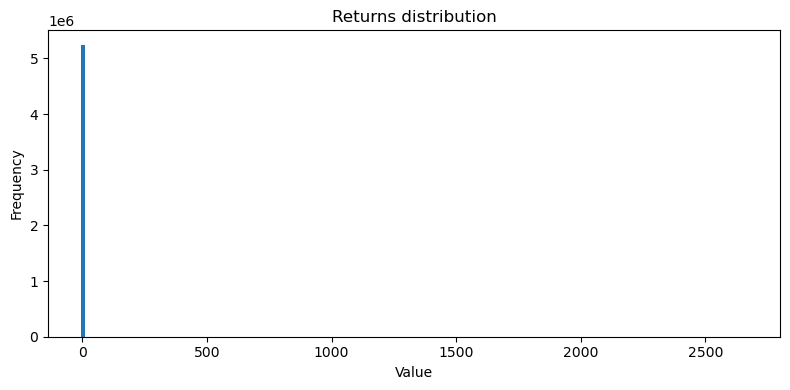

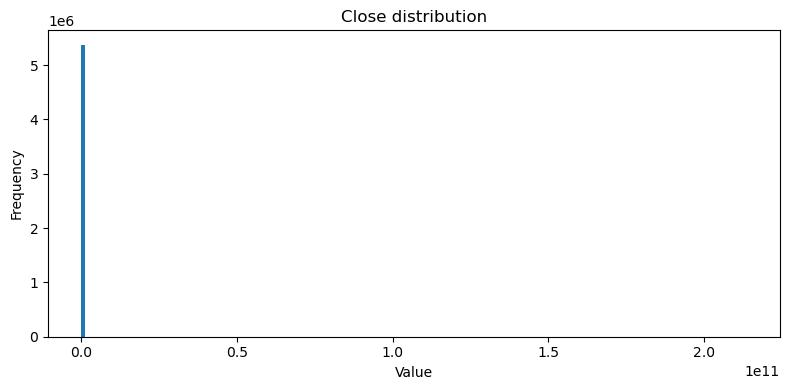

C:\Users\g3055\AppData\Local\Temp\ipykernel_9900\216571597.py:86: RuntimeWarning: invalid value encountered in log
  _plot_hist(np.log(close.to_numpy().astype(float)).ravel(), "Log(Close) distribution", bins=200, filename=f"{outdir}/hist_log_close.png")


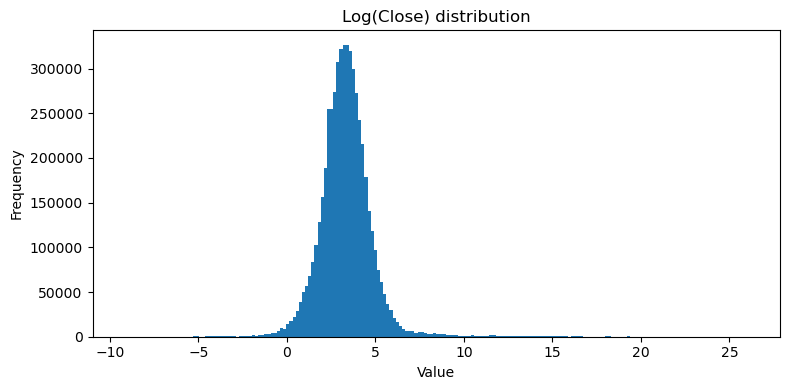

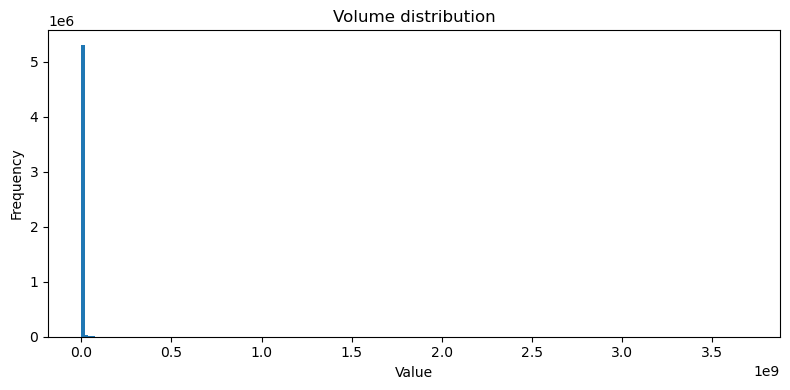

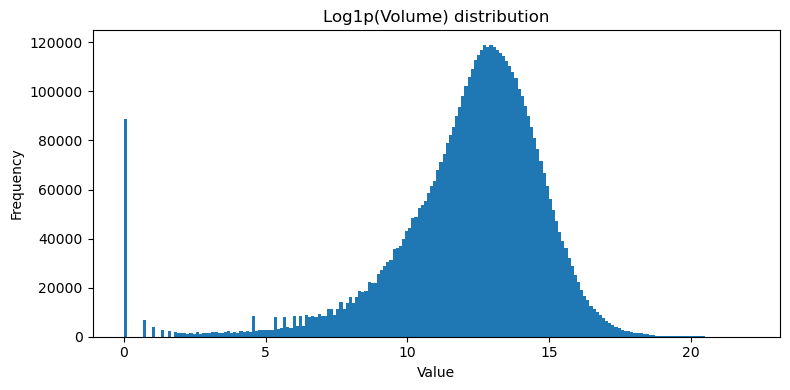

           count  missing_pct        min        1%           5%           25%  \
name                                                                            
returns  7372197    28.892459  -3.758620 -0.097927    -0.047847     -0.012431   
close    7372197    27.113966 -37.709606  0.890000     3.180000     12.112698   
volume   7372197    27.113966   0.000000  0.000000  1030.000000  59200.000000   

                   50%           75%           95%           99%  \
name                                                               
returns       0.000000  1.264287e-02  4.829209e-02  1.105958e-01   
close        26.712832  5.845000e+01  2.348000e+02  4.500000e+03   
volume   295500.000000  1.077900e+06  5.947203e+06  2.064960e+07   

                  max          mean           std         skew      kurtosis  \
name                                                                           
returns  2.665667e+03  2.160561e-03  1.450863e+00  1419.398938  2.334878e+06   
close    2.13

In [4]:
# 1) Paste/define this in your notebook once:
# (If you see 'Helper defined...' printed, you're good.)

# --- begin helper ---
import numpy as np, pandas as pd, matplotlib.pyplot as plt

from typing import Optional, Dict, Any
from scipy.stats import skew, kurtosis

def distribution_report(close: pd.DataFrame,
                        volume: pd.DataFrame,
                        open_df: Optional[pd.DataFrame] = None,
                        outdir: str = "/mnt/data",
                        returns_fill_method: Optional[str] = None,  # None avoids forward-fill
                        price_log: bool = True,
                        volume_log: bool = True) -> Dict[str, Any]:
    import os
    os.makedirs(outdir, exist_ok=True)

    def _flatten(df): return df.to_numpy().ravel()
    def _mad(x):
        med = np.nanmedian(x); return float(np.nanmedian(np.abs(x - med)))
    def _skew_safe(x):
        try: return float(skew(x, bias=False, nan_policy="omit"))
        except: return np.nan
    def _kurt_safe(x):
        try: return float(kurtosis(x, fisher=True, bias=False, nan_policy="omit"))
        except: return np.nan
    def _series_summary(arr, name):
        x = pd.Series(arr, dtype='float64'); n = int(x.shape[0]); n_nan = int(x.isna().sum()); x = x.dropna()
        if x.empty:
            return pd.Series({"name": name, "count": n, "missing_pct": 100.0, "min": np.nan, "1%": np.nan, "5%": np.nan,
                              "25%": np.nan, "50%": np.nan, "75%": np.nan, "95%": np.nan, "99%": np.nan, "max": np.nan,
                              "mean": np.nan, "std": np.nan, "skew": np.nan, "kurtosis": np.nan, "MAD": np.nan})
        qs = x.quantile([0.01,0.05,0.25,0.50,0.75,0.95,0.99])
        return pd.Series({
            "name": name, "count": n, "missing_pct": 100.0*n_nan/max(1,n),
            "min": float(x.min()), "1%": float(qs.loc[0.01]), "5%": float(qs.loc[0.05]),
            "25%": float(qs.loc[0.25]), "50%": float(qs.loc[0.50]), "75%": float(qs.loc[0.75]),
            "95%": float(qs.loc[0.95]), "99%": float(qs.loc[0.99]), "max": float(x.max()),
            "mean": float(x.mean()), "std": float(x.std(ddof=1)),
            "skew": _skew_safe(x.values), "kurtosis": _kurt_safe(x.values), "MAD": _mad(x.values)
        })
    def _plot_hist(x, title, bins=200, filename=None):
        x = pd.Series(x, dtype='float64').dropna().values
        if x.size == 0: return
        plt.figure(figsize=(8,4)); plt.hist(x, bins=bins); plt.title(title); plt.xlabel("Value"); plt.ylabel("Frequency")
        plt.tight_layout(); 
        if filename: plt.savefig(filename, dpi=140)
        plt.show()
    def _winsor_suggest(x, q_low=0.005, q_high=0.995, k_mad=7.0):
        s = pd.Series(x, dtype='float64').dropna()
        if s.empty: return {"q_low": np.nan, "q_high": np.nan, "mad_low": np.nan, "mad_high": np.nan}
        ql,qh = s.quantile([q_low, q_high]).values
        med = s.median(); mad = _mad(s.values); sigma = 1.4826*mad if np.isfinite(mad) else np.nan
        return {"q_low": float(ql), "q_high": float(qh),
                "mad_low": float(med - 7*sigma) if np.isfinite(sigma) else np.nan,
                "mad_high": float(med + 7*sigma) if np.isfinite(sigma) else np.nan}

    volume = volume.reindex_like(close)
    if open_df is not None: open_df = open_df.reindex_like(close)

    rets = close.pct_change(fill_method=returns_fill_method)

    summ = []
    summ.append(_series_summary(_flatten(rets), "returns"))
    summ.append(_series_summary(_flatten(close), "close"))
    summ.append(_series_summary(_flatten(volume), "volume"))
    if open_df is not None: summ.append(_series_summary(_flatten(open_df), "open"))
    summary_df = pd.DataFrame(summ).set_index("name")
    summary_path = f"{outdir}/distribution_summary.csv"; summary_df.to_csv(summary_path)

    missingness = {
        "returns_missing_pct": float(pd.isna(rets).mean().mean()*100),
        "close_missing_pct": float(pd.isna(close).mean().mean()*100),
        "volume_missing_pct": float(pd.isna(volume).mean().mean()*100),
        **({"open_missing_pct": float(pd.isna(open_df).mean().mean()*100)} if open_df is not None else {})
    }

    winsor = _winsor_suggest(_flatten(rets))
    winsor_df = pd.DataFrame([winsor]); winsor_df.to_csv(f"{outdir}/winsor_suggestions.csv", index=False)

    _plot_hist(_flatten(rets), "Returns distribution", bins=200, filename=f"{outdir}/hist_returns.png")
    _plot_hist(_flatten(close), "Close distribution", bins=200, filename=f"{outdir}/hist_close.png")
    if True:
        _plot_hist(np.log(close.to_numpy().astype(float)).ravel(), "Log(Close) distribution", bins=200, filename=f"{outdir}/hist_log_close.png")
    _plot_hist(_flatten(volume), "Volume distribution", bins=200, filename=f"{outdir}/hist_volume.png")
    if True:
        _plot_hist(np.log1p(volume.to_numpy().astype(float)).ravel(), "Log1p(Volume) distribution", bins=200, filename=f"{outdir}/hist_log1p_volume.png")
    if open_df is not None:
        _plot_hist(_flatten(open_df), "Open distribution", bins=200, filename=f"{outdir}/hist_open.png")
        _plot_hist(np.log(open_df.to_numpy().astype(float)).ravel(), "Log(Open) distribution", bins=200, filename=f"{outdir}/hist_log_open.png")

    print(summary_df)

    return {"summary_csv": summary_path, "winsor_suggestions": winsor, "missingness": missingness}
# --- end helper ---
# 2) Run it on your panel
report = distribution_report(close, volume)  # 'open' optional
print(report["winsor_suggestions"])
print(report["missingness"])


In [5]:
def build_tradable_mask(
    close: pd.DataFrame,
    volume: pd.DataFrame,
    min_price: float = 1.0,
    min_vol: float = 1.0,
) -> pd.DataFrame:
    """
    Return a boolean (dates × tickers) mask where a name is tradable iff:
      - close and volume are finite
      - close >= min_price
      - volume >= min_vol
    You can AND this with your top-3000 membership mask if you have one.
    """
    mask = (
        close.notna() & volume.notna() &
        np.isfinite(close) & np.isfinite(volume) &
        (close >= min_price) & (volume >= min_vol)
    )
    return mask